## Detecting Deforestation

For the rest of the course, we've been speeding through various aspects of neural networks and deep learning: forward feed/back propagation, gradient descent, CNNs, RNNs, and GANs. 

Like most of you reading this, I've been speeding through each week, trying to both grasp the theoretical background of each topic as well as learn how to implement using the Keras/TF library. Between data preprocessing and understanding each of the methods within the packages, it's been more than enough to plug in the right implementation and move on.

In this final project, I'm going back to CNNs, the week I most enjoyed throughout the course, and comparing a baseline model with another with a second model I intent to tune extensively. Thanks for reading/reviewing.

## Introduction / Problem Statement

This problem is intented to teach the implementation of a CNN in Python in order to classify images based on the presence of deforestation. Specifically, the training data is labelled a 1 or a 0, depending on whether the image contains a coffee plantation--within this dataset/problem area, a coffee plantation is the most common use of of land where deforestation has occurred.

The data provided for this problem actually doesn't include any images at all. For training our model, we will use two .txt files, both space delimited, with greyscale 1D pixel values in our "x" dataset and labels in our "y" dataset. 

There are 1,440 sets of pixel values within our .txt file, and each "image" contains 400 pixels, or a 20x20 array (although we will have to structure it below). 

Our test dataset is stored as a .csv file with column labels, again having 20x20 pixel values without corresponding y labels.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, optimizers

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [3]:
PATH = '/kaggle/input/dsc6232-rwanda-summer2021-hw2/'

with open(PATH+'X_train.txt') as f:
    x_train = f.readlines()
    
with open(PATH+'y_train.txt') as f:
    y_train = f.readlines()
    
for i in range(0, len(y_train)):
    y_train[i] = int(float(y_train[i].rstrip('\n')))
y_train = np.array(y_train)
    
for j in range(0, len(x_train)):
    x_train[j] = x_train[j].split(' ')
    for f in range(0, len(x_train[j])):
        x_train[j][f] = float(x_train[j][f])
    x_train[j] = np.array(x_train[j]).reshape(20,20)
x_train = np.array(x_train)

print(len(x_train))
print(len(y_train))

1440
1440


## Exploratory Data Analysis

Below, we'll see that we have 1,440 images that are 20x20 pixels, with a single greyscale value. Above, we reshaped each array into the right orientation.

In [4]:
print(x_train.shape)
print(y_train.shape)

x_train = np.reshape(x_train, (1440, 20, 20, 1))
x_train.shape

(1440, 20, 20)
(1440,)


(1440, 20, 20, 1)

We can also take a look at a handful of images with our corresponding labels.

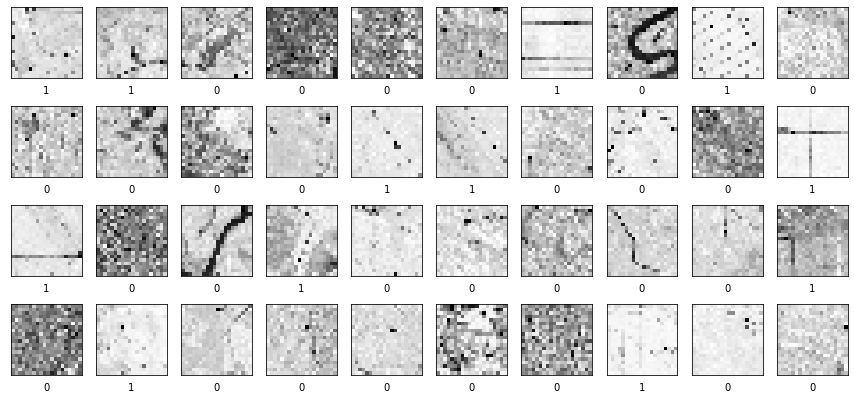

In [5]:
fig, ax = plt.subplots(4, 10, figsize=(15, 7))
for i, axis in enumerate(ax.flat):
    axis.imshow(x_train[i], cmap='Greys')
    axis.set(xticks=[], yticks=[], xlabel = y_train[i]);

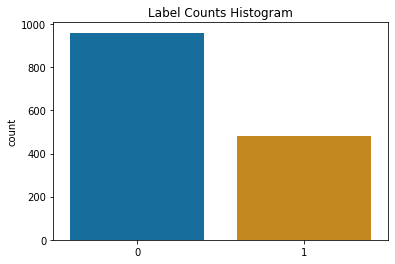

In [6]:
sns.countplot(x=y_train, 
              palette='colorblind').set(title='Label Counts Histogram');

Before preprocessing, we can see that the minimimum pixel value is 0, with the maximum value being 253. This makes sense, given we know the range for these types of values is 0 to 255.

In [7]:
maxi = 0
mini = 255
for f in range(0, len(x_train)):
    for y in range(0, len(x_train[f])):
        for l in range(0, len(x_train[f][y])):
            if x_train[f][y][l] > maxi:
                maxi = x_train[f][y][l]
            if x_train[f][y][l] < mini:
                mini = x_train[f][y][l]           
print(mini, maxi)

[0.] [253.]


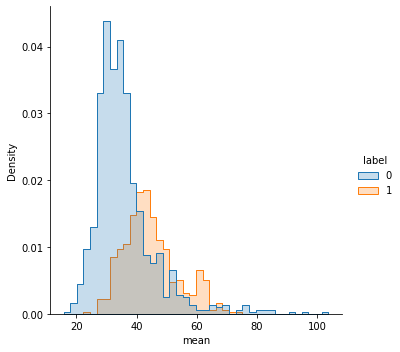

In [8]:
means = {'label':[], 'mean':[]}

for i in range(0, len(x_train)):
    if y_train[i] == 0:
        means['label'].append(0)
        means['mean'].append(np.mean(x_train[i]))
    else:
        means['label'].append(1)
        means['mean'].append(np.mean(x_train[i]))

dist_df = pd.DataFrame(means)
sns.displot(dist_df, x = dist_df['mean'], hue = dist_df['label'], element="step", stat = 'density')

What we see from the above chart is the average pixel value for images labeled 0 are generally lower than images labeled 1, and are also more tightly packed around an average in the low to mid 30s. There is also more variation in the darkness/brightness of images labelled 1.

## Data Preprocessing

In [9]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [10]:
BATCH = 32

with strategy.scope():
    training_generator = datagen.flow(x_train,
                                    y=y_train,
                                    batch_size=BATCH,
                                    shuffle=True,
                                    subset = 'training')

In [11]:
with strategy.scope():
    validation_generator = datagen.flow(x_train,
                                        y = y_train,
                                        batch_size = BATCH,
                                        shuffle = True,
                                        subset = 'validation')

## Model Architecture

Below, we start with our baseline model.

In [12]:
with strategy.scope():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(32, 20, 20, 1)) 

2022-11-11 15:37:54.089300: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (32, 18, 18, 16)          160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 9, 9, 16)            0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 7, 7, 32)            4640      
_________________________________________________________________
average_pooling2d (AveragePo (32, 3, 3, 32)            0         
_________________________________________________________________
flatten (Flatten)            (32, 288)                 0         
_________________________________________________________________
dense (Dense)                (32, 10)                  2890      
_________________________________________________________________
dense_1 (Dense)              (32, 1)                   1

In [14]:
with strategy.scope():
    model.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()], optimizer = optimizers.Adam(learning_rate=0.001))

In [15]:
history = model.fit_generator(training_generator, epochs=50, validation_data = validation_generator)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-11 15:37:54.416506: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
36/36 [==============================] - 2s 20ms/step - loss: 0.8444 - accuracy: 0.3828 - auc: 0.4663 - val_loss: 0.6431 - val_accuracy: 0.6910 - val_auc: 0.2870
Epoch 2/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6459 - accuracy: 0.6606 - auc: 0.4237 - val_loss: 0.6200 - val_accuracy: 0.6910 - val_auc: 0.3247
Epoch 3/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6423 - accuracy: 0.6606 - auc: 0.3453 - val_loss: 0.6192 - val_accuracy: 0.6910 - val_auc: 0.5000
Epoch 4/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6417 - accuracy: 0.6606 - auc: 0.4553 - val_loss: 0.6195 - val_accuracy: 0.6910 - val_auc: 0.5000
Epoch 5/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6411 - accuracy: 0.6606 - auc: 0.4961 - val_loss: 0.6195 - val_accuracy: 0.6910 - val_auc: 0.5000
Epoch 6/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6410 - accuracy: 0.6606 - auc: 0.4808 - val_loss: 0.6199 - val_ac

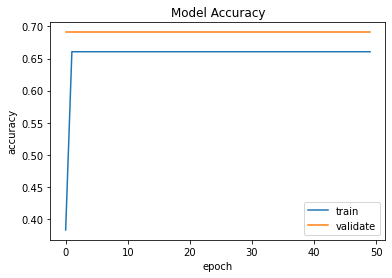

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.show()

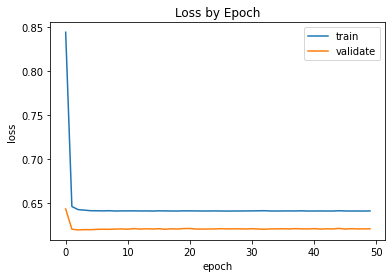

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss by Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.show()

What we see using this baseline model is that through 50 epochs, we are still probably not converging, given that accuracy is still increasing and our loss measures are still decreasing. Additionally, our training and validation subsets are remaining quite tight with each other through accuracy of 80% or so near the end of training meaning we are likely not overfitting. Turning that one into Kaggle, it pops out a score in the upper 70s. Can we do better??

Time to try a second model. Here's a few changes I implement below, trying each one at a time during the architecture phase of the study to make sure they each has a positive impact. This entailed running the model over and over with some back-steps when I began overfitting. Fortunately, the competition has no limit to daily submissions, in case you want to try as well.
* Add more convolution layers (and add more filters within each of tehse layers).
* Add batch normalization (to increase validation accuracy).
* Add dropout layers (to reduce overfitting).
* Add more training epochs (but also utilize early stopping to make sure we don't overfit).

In [18]:
with strategy.scope():
    model_v2 = models.Sequential()
    model_v2.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_v2.add(layers.MaxPooling2D(pool_size=(2,2)))
    model_v2.add(layers.BatchNormalization())
    model_v2.add(layers.Dropout(0.25))
    
    model_v2.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model_v2.add(layers.MaxPooling2D(pool_size=(2,2)))
    model_v2.add(layers.BatchNormalization())
    model_v2.add(layers.Dropout(0.25))
    
    model_v2.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model_v2.add(layers.BatchNormalization())
    model_v2.add(layers.Dropout(0.25))
    
    model_v2.add(layers.Flatten())
    model_v2.add(layers.Dense(10, activation='sigmoid'))
    model_v2.add(layers.Dropout(0.25))
    model_v2.add(layers.Dense(1, activation='sigmoid'))
    model_v2.build(input_shape=(32, 20, 20, 1)) 

In [19]:
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (32, 18, 18, 32)          320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 9, 9, 32)            0         
_________________________________________________________________
batch_normalization (BatchNo (32, 9, 9, 32)            128       
_________________________________________________________________
dropout (Dropout)            (32, 9, 9, 32)            0         
_________________________________________________________________
conv2d_3 (Conv2D)            (32, 7, 7, 64)            18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 3, 3, 64)            0         
_________________________________________________________________
batch_normalization_1 (Batch (32, 3, 3, 64)           

One final change for our more tuned model: reading through the competition guidelines, we can see that submissions are not actually graded using accuracy, but instead F1, which is a slightly different measure which utilizes both the precision and recall of the output to score.

Because of this, it's important to make sure our model is training based on the metric we will be scored against. Below, I've leveraged an f1 function (with citation) which can then be called in the compiler.

In [20]:
## F1 for compiler, here: https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default%2C%20f1%20score%20is,like%20accuracy%2C%20categorical%20accuracy%20etc.
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
with strategy.scope():
    model_v2.compile(loss='binary_crossentropy', metrics=[get_f1], optimizer = optimizers.Adamax(learning_rate=0.001))

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history_v2 = model_v2.fit_generator(training_generator, epochs=300, validation_data = validation_generator, callbacks = [callback])

Epoch 1/300
36/36 [==============================] - 2s 23ms/step - loss: 0.5696 - get_f1: 0.4993 - val_loss: 0.6276 - val_get_f1: 0.0000e+00
Epoch 2/300
36/36 [==============================] - 1s 14ms/step - loss: 0.5058 - get_f1: 0.6399 - val_loss: 0.6098 - val_get_f1: 0.0000e+00
Epoch 3/300
36/36 [==============================] - 1s 15ms/step - loss: 0.4849 - get_f1: 0.6446 - val_loss: 0.6149 - val_get_f1: 0.0000e+00
Epoch 4/300
36/36 [==============================] - 1s 15ms/step - loss: 0.4626 - get_f1: 0.6832 - val_loss: 0.6674 - val_get_f1: 0.0000e+00
Epoch 5/300
36/36 [==============================] - 1s 15ms/step - loss: 0.4475 - get_f1: 0.6976 - val_loss: 0.7241 - val_get_f1: 0.0000e+00
Epoch 6/300
36/36 [==============================] - 1s 15ms/step - loss: 0.4476 - get_f1: 0.7185 - val_loss: 0.7658 - val_get_f1: 0.0000e+00
Epoch 7/300
36/36 [==============================] - 1s 15ms/step - loss: 0.4268 - get_f1: 0.7049 - val_loss: 0.8055 - val_get_f1: 0.0000e+00
Epoch 

## Results/Analysis

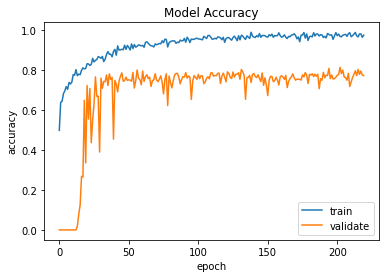

In [23]:
plt.plot(history_v2.history['get_f1'])
plt.plot(history_v2.history['val_get_f1'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.show()

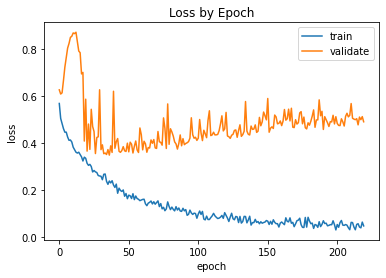

In [24]:
plt.plot(history_v2.history['loss'])
plt.plot(history_v2.history['val_loss'])
plt.title('Loss by Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.show()

So how did we do? Above, you can see the results of my "best" run, which eventually scored me near the top of the (now closed) leaderboard, with public/private scores of 0.956 and 0.939. Which hyperparameters seemed to have the greatest effect?

First, adding more convolutional layers and filters helped tremendously, as did adding more epochs. This would of course slow down the training step, although for such a small dataset, we're talking in the magnitude of seconds rather than hours. Because the first model was so simple (by trainable parameters as well as filters), clearly we weren't pulling out all aspects of the images we were training on. However, after making these changes, it was clear that the model was overfitting, as validation loss would eventually increase dramatically. I added in batch normalization and dropout layers, but importantly also added in early stopping (which in the final model wasn't actually utilized), further tuning the "patience" hyperparameter within early stopping to be incredibly forgiving (20).

One of the other single biggest changes was utilizing the f1 scoring function rather than straight "accuracy." This helped my model jump in score by at least 2-3 percentage points. Intuitively, this actually makes sense, given we were training the model using a metric it wouldn't actually be scored on.

In [25]:
with open(PATH+'X_test_df.csv') as f:
    x_test = f.readlines()

for j in range(1, len(x_test)):
    x_test[j] = x_test[j].split(',')
    x_test[j] = x_test[j][1:]
    for f in range(0, len(x_test[j])):
        x_test[j][f] = float(x_test[j][f])
    x_test[j] = np.array(x_test[j]).reshape(20,20)
x_test = x_test[1:]    
x_test = np.array(x_test)

print(x_test.shape)
x_test = np.reshape(x_test, (476, 20, 20, 1))
print(x_test.shape)

(476, 20, 20)
(476, 20, 20, 1)


In [26]:
#test_images = pd.DataFrame({'id':os.listdir(test_path)})
testing_datagen = ImageDataGenerator(rescale=1./255.)
testing_generator = testing_datagen.flow(x=x_test, 
                                         batch_size=1, 
                                         shuffle=False)

In [27]:
predict = model.predict(testing_generator, verbose=1)

476/476 [==============================] - 1s 2ms/step


In [28]:
predict_v2 = model_v2.predict(testing_generator, verbose=1)

476/476 [==============================] - 1s 2ms/step


In [29]:
active_model_preds = predict_v2

submit = pd.DataFrame()
submit['index'] = np.arange(0, 476, 1)
submit['label'] = list(map(lambda x: 0 if x < 0.5 else 1, active_model_preds))
print(submit.head(10))
submit.to_csv('output.csv', index=False)

   index  label
0      0      0
1      1      0
2      2      0
3      3      0
4      4      0
5      5      0
6      6      1
7      7      0
8      8      1
9      9      0


## Conclusion

This was a fun final project, especially given that after rushing through the rest of the course, I had the breathing room to really sit with the models I was developing, as well as the training data, to fully play with many of the hyperparameters. It gave me a great sense of the give and take between under-cooking your solution and overdoing a model.

With that in mind, below are three takeaways that most specifically pertain to the exercise above, but I think are also generalizable to deep learning as a whole.

1. Overfit your model!... and then pull back a bit. What I mean by this is that it's easy to slowly add elements to your model to try and bump up your score very piecemeal, but this can be an arduous process, especially in very complex models with so many parameters to tweak. It's sometimes quickest to "go for the gold" and overfit your model, and then back up and implement in a way that minimizes that overfit. In general, it's not hard to detect overfitting, so (with reasonable computing power) this can be the best way to move forward.
2. Make sure to train on the right metrics. What was interesting about the cancer detection study during our CNN week was the use of accuracy as the metric. Although it is just a Kaggle exercise with scrubbed data an no real-world implications, that is a situation where you would absolutely want to maximize the recall of the model rather than the accuracy, given the consequences of falsely "detecting" cancer in a patient is rather low compared to falsely missing the presence of cancer in a patient (which is incredibly high). In real-world situations, it's important to select the right metric to train on, and in these competitions, it's easy to see that training on the metric you'll be evaluated on can really help your performance.
3. Sometimes, it helps to havea baseline model to compare against. Although my baseline model was the poorest performing of all my attempts, I did have a few times where a (usually overfit) model would perform nearly as poorly. By that point, I had added enough new layers and tweaked enough hyperparameters to sort of lose track of what changes I had made. Knowing where you started, with a baseline model, and keeping track via version control, change logs, commits, etc. can really help you backtrack to your best-case model, identifying the one you actually want to implement.

I hope this course has been as helpful for you as it has for me. Best of luck in the rest of your studies!